In [ ]:
!pip install torchmetrics

In [3]:
URL_BASE="https://raw.githubusercontent.com/ggonzalesd/Deep-Learning-Project/dev"
!curl $URL_BASE/callback.py --output callback.py
!curl $URL_BASE/brain_tumor_dataset.py --output brain_tumor_dataset.py
!curl $URL_BASE/models_01.py --output models_01.py
!curl $URL_BASE/test_models_01.py --output test_models_01.py
!curl $URL_BASE/models_02.py --output models_02.py
!curl $URL_BASE/test_models_02.py --output test_models_02.py
!curl $URL_BASE/models_03.py --output models_03.py
!curl $URL_BASE/test_models_03.py --output test_models_03.py
!curl $URL_BASE/plots.py --output plots.py
!curl $URL_BASE/trainer.py --output trainer.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2515  100  2515    0     0  13594      0 --:--:-- --:--:-- --:--:-- 13594
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   640  100   640    0     0   3076      0 --:--:-- --:--:-- --:--:--  3076
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2035  100  2035    0     0  10544      0 --:--:-- --:--:-- --:--:-- 10489
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2660  100  2660    0     0  13502      0 --:--:-- --:--:-- --:--:-- 13502
  % Total    % Received % Xferd  Average Speed   Tim

In [1]:
import h5py                                           # Read .Mat Files
import random                                         # Get random integers
import pandas as pd                                   # Read CSV
import numpy as np                                    # Transform and save arrays
from skimage.draw import polygon                      # Create images from points
from prettytable import PrettyTable # Table of results

import torch                                          # Framework
from torch import optim                               # optim: Adam, SDG
from torch import nn

from torch.utils import data                          # Data
from torchvision import transforms                    # Transform dataset images
import torchmetrics

import matplotlib.pyplot as plt                       # Visualize images and more
import seaborn as sns
from tqdm import tqdm

import plots
from brain_tumor_dataset import BrainTumorDataset     # Dataset
from callback import EarlyStopping, ModelCheckpoint
from trainer import Trainer          # Trainer Class
from models_01 import BrainNet_V3 as BrainNet_A_V3, BrainMobilenet
from models_02 import BrainNetv4 as BrainNet_B_V4, BrainGoogleNet
from models_03 import BrainNetv1R as BrainNet_C_V1, BrainResNet

/home/poggers/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Preprocessing Dataset | (from .mat to .npy) 📥
Download and unzip dataset

In [ ]:
!curl https://figshare.com/ndownloader/articles/1512427/versions/5 --output data.zip
!mkdir tmp_dataset
!mkdir dataset
!unzip data.zip -d ./tmp_dataset
!for file in ./tmp_dataset/*.zip; do unzip $file -d ./tmp_dataset/; done
!rm ./tmp_dataset/*.zip

Convert .mat to .npy

In [6]:
data_tmp = {'image':[], 'label':[]}
index = 0
for i in tqdm(range(3064)):
  with h5py.File(f"tmp_dataset/{i+1}.mat", 'r') as f:
    image = f.get('cjdata/image')
    img = np.array(image, dtype=np.float32)
    if img.shape == (512, 512):
      border = np.array(f.get('cjdata/tumorBorder')).reshape((-1, 2))
      name = f"{index+1}.npy"
      img = img / img.max()

      mask = np.zeros_like(img, dtype=np.float32)
      rr, cc = polygon(border[:,0], border[:,1], img.shape)
      mask[rr,cc] = 1.0

      result = np.stack([img, mask], axis=2)

      np.save("./dataset/"+name, result)
      data_tmp['image'].append(name)
      data_tmp['label'].append(np.array(f.get('cjdata/label'), dtype=np.int64).item()-1)
      index += 1
!rm -rf tmp_dataset

save Labels

In [11]:
df = pd.DataFrame(data_tmp)
df.to_csv('./dataset/data.csv', index=False)
df.head()
del df, data_tmp

# Config Device and Seed 🖥 🎲

In [ ]:
!nvidia-smi

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using {}'.format(device))

Using cpu


In [3]:
seed = 42
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
#torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = False

# Load Dataset and Create DataLoaders 💽

In [1]:
# Load Dataset
BATCH_SIZE = 16
EPOCHS = 20
HEADERS = ["Model", "Train loss", "Val Loss", "Train Acc", "Val Acc", "Paramers"]
CLASS_NAMES = ['Meningioma', 'Glioma', 'Pituitary']

dataset = BrainTumorDataset(
  csv_file='dataset/data.csv',
  root_dir='dataset',
  transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
  ])
)

train_data, test_data = plots.split_dataset(dataset)
len(train_data), len(test_data)

NameError: name 'BrainTumorDataset' is not defined

In [9]:
# Split train_data for training and validation
train_set, val_set = plots.split_dataset(train_data, train_size=0.75)

print('Original dataset size: ', len(dataset))
print('---------------------------')
print('Training data size: ', len(train_set))
print('Validation data size: ', len(val_set))
print('Test data size: ', len(test_data))

Original dataset size:  3049
---------------------------
Training data size:  1829
Validation data size:  610
Test data size:  610


In [10]:
# Create Loaders
train_dl = data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_dl = data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_dl = data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

print('Number of batches')
print('---------------------')
print('Training data: ', len(train_dl))
print('Validation data: ', len(val_dl))
print('Test data: ', len(test_dl))

Number of batches
---------------------
Training data:  58
Validation data:  20
Test data:  20


# Visualization of Dataset 👀

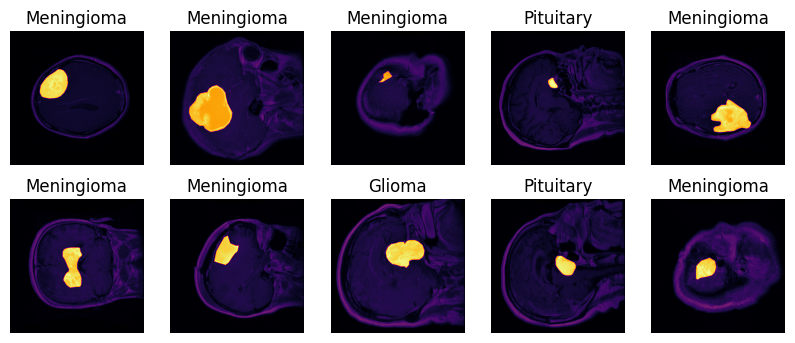

In [7]:
X_batch, y_batch = next(iter(val_dl))
plt.figure(figsize=(10, 4))
for i in range(10):
  image = (X_batch[i]*0.5 + 0.5).numpy()

  mask = 0.5*image[0,:,:] + image[1,:,:]

  plt.subplot(2, 5, i+1)
  plt.axis('off')
  plt.title(str(CLASS_NAMES[y_batch[i].item()-1]))
  plt.imshow(mask, cmap='inferno')

In [ ]:
!python -m pytest test_models_01.py
!python -m pytest test_models_02.py
!python -m pytest test_models_03.py

# Training 💪 🏋️

## BrainNet A V3 Lr(1e-3) Wr(1e-6)

In [ ]:
model = BrainNet_A_V3()
brainnet_a_v3_lr3_wr6_num_params = plots.total_num_parameters(model)

optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-6)
lr_schedule = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15, eta_min=1e-4)

brainnet_a_v3_lr3_wr6_ckp = ModelCheckpoint('brainnet_a_v3_lr3_wr6.pt', mode='min', monitor='val_loss', verbose=False)

trainer = Trainer(brainnet_a_v3_lr3_wr6_ckp)

brainnet_a_v3_lr3_wr6_results = trainer.train(train_dl, val_dl, model, EPOCHS, optimizer, device, lr_schedule)

In [ ]:
plots.plot_model_results("BrainNet A V3 Lr(1e-3) Wr(1e-6)", brainnet_a_v3_lr3_wr6_results)

In [ ]:
plots.print_table(HEADERS,[
plots.row("BrainNet A V3 Lr(1e-3) Wr(1e-6)",brainnet_a_v3_lr3_wr6_ckp.best_results)+[brainnet_a_v3_lr3_wr6_num_params],
])

# BrainMobilenet lr4 wr8

In [ ]:
model = BrainMobilenet()
brainmobilenet_lr4_wr8_num_params = plots.total_num_parameters(model)

feat_params = list(model.backbone.parameters())
clf_params = list(model.classifier.parameters())

parameters = [
    {'params': feat_params, 'lr':1e-6, 'weight_decay': 1e-10},
    {'params': clf_params, 'lr':1e-4, 'weight_decay': 1e-8},
]

optimizer = optim.AdamW(parameters)
lr_schedule = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15, eta_min=1e-4)

brainmobilenet_lr4_wr8_ckp = ModelCheckpoint('brainmobilenet_lr4_wr8.pt', mode='min', monitor='val_loss', verbose=False)

trainer = Trainer(brainmobilenet_lr4_wr8_ckp, three_channels=True)

brainmobilenet_lr4_wr8_results = trainer.train(train_dl, val_dl, model, EPOCHS, optimizer, device, lr_schedule)

In [ ]:
plots.plot_model_results("BrainMobile Lr(1e-4) Wr(1e-8)", brainmobilenet_lr4_wr8_results)

In [ ]:
plots.print_table(HEADERS,[
plots.row("BrainNet A V3 Lr(1e-3) Wr(1e-6)",brainnet_a_v3_lr3_wr6_ckp.best_results)+[brainnet_a_v3_lr3_wr6_num_params],
plots.row("BrainMobile Lr(1e-4) Wr(1e-8)",brainmobilenet_lr4_wr8_ckp.best_results)+[brainmobilenet_lr4_wr8_num_params]
])

## Brainet B V4

In [ ]:
model = BrainNet_B_V4()
brainnet_b_v4_lr3_wr6_num_params = plots.total_num_parameters(model)

optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-6)
lr_schedule = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15, eta_min=1e-4)

brainnet_b_v4_lr3_wr6_ckp = ModelCheckpoint('brainnet_b_v4_lr3_wr6.pt', mode='min', monitor='val_loss', verbose=False)

trainer = Trainer(brainnet_b_v4_lr3_wr6_ckp)

brainnet_b_v4_lr3_wr6_results = trainer.train(train_dl, val_dl, model, EPOCHS, optimizer, device, lr_schedule)

In [ ]:
plots.plot_model_results("Brainnet B v4 Lr(1e-3) Wr(1e-6)", brainnet_b_v4_lr3_wr6_results)

In [ ]:
plots.print_table(HEADERS,[
plots.row("BrainNet A V3 Lr(1e-3) Wr(1e-6)",brainnet_a_v3_lr3_wr6_ckp.best_results)+[brainnet_a_v3_lr3_wr6_num_params],
plots.row("BrainMobile Lr(1e-4) Wr(1e-8)",brainmobilenet_lr4_wr8_ckp.best_results)+[brainmobilenet_lr4_wr8_num_params],
plots.row("Brainnet B v4 Lr(1e-3) Wr(1e-6)",brainnet_b_v4_lr3_wr6_ckp.best_results)+[brainnet_b_v4_lr3_wr6_num_params]
])

## Brainet GoogleNet

In [ ]:
model = BrainGoogleNet()
brainet_googlenet_lr4_wr8_num_params = plots.total_num_parameters(model)

feat_params = list(model.backbone.parameters())
clf_params = list(model.classifier.parameters())

parameters = [
    {'params': feat_params, 'lr':1e-3, 'weight_decay': 1e-10},
    {'params': clf_params, 'lr':1e-4, 'weight_decay': 1e-8},
]

optimizer = optim.AdamW(parameters)
lr_schedule = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15, eta_min=1e-5)

brainet_googlenet_lr4_wr8_ckp = ModelCheckpoint('brainnet_googlenet_lr4_wr8.pt', mode='min', monitor='val_loss', verbose=False)

trainer = Trainer(brainet_googlenet_lr4_wr8_ckp, three_channels=True)

brainet_googlenet_lr4_wr8_results = trainer.train(train_dl, val_dl, model, EPOCHS, optimizer, device, lr_schedule)

In [ ]:
plots.plot_model_results("Brainnet GoogleNet Lr(1e-4) Wr(1e-8)", brainet_googlenet_lr4_wr8_results)

In [ ]:
plots.print_table(HEADERS,[
plots.row("BrainNet A V3 Lr(1e-3) Wr(1e-6)",brainnet_a_v3_lr3_wr6_ckp.best_results)+[brainnet_a_v3_lr3_wr6_num_params],
plots.row("BrainMobile Lr(1e-4) Wr(1e-8)",brainmobilenet_lr4_wr8_ckp.best_results)+[brainmobilenet_lr4_wr8_num_params],
plots.row("Brainnet B v4 Lr(1e-3) Wr(1e-6)",brainnet_b_v4_lr3_wr6_ckp.best_results)+[brainnet_b_v4_lr3_wr6_num_params],
plots.row("Brainnet GoogleNet Lr(1e-4) Wr(1e-8)",brainet_googlenet_lr4_wr8_ckp.best_results)+[brainet_googlenet_lr4_wr8_num_params]
])

## BrainNet C V1

In [ ]:
model = BrainNet_C_V1()
brainnet_c_v1_lr3_wr6_num_params = plots.total_num_parameters(model)

optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-6)
lr_schedule = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15, eta_min=1e-4)

brainnet_c_v1_lr3_wr6_ckp = ModelCheckpoint('brainnet_c_v1_lr3_wr6.pt', mode='min', monitor='val_loss', verbose=False)

trainer = Trainer(brainnet_c_v1_lr3_wr6_ckp)

brainnet_c_v1_lr3_wr6_results = trainer.train(train_dl, val_dl, model, EPOCHS, optimizer, device, lr_schedule)

In [ ]:
plots.plot_model_results("Brainnet C v1 Lr(1e-3) Wr(1e-6)", brainnet_c_v1_lr3_wr6_results)

In [ ]:
plots.print_table(HEADERS,[
plots.row("BrainNet A V3 Lr(1e-3) Wr(1e-6)",brainnet_a_v3_lr3_wr6_ckp.best_results)+[brainnet_a_v3_lr3_wr6_num_params],
plots.row("BrainMobile Lr(1e-4) Wr(1e-8)",brainmobilenet_lr4_wr8_ckp.best_results)+[brainmobilenet_lr4_wr8_num_params],
plots.row("Brainnet B v4 Lr(1e-3) Wr(1e-6)",brainnet_b_v4_lr3_wr6_ckp.best_results)+[brainnet_b_v4_lr3_wr6_num_params],
plots.row("Brainnet GoogleNet Lr(1e-4) Wr(1e-8)",brainet_googlenet_lr4_wr8_ckp.best_results)+[brainet_googlenet_lr4_wr8_num_params],
plots.row("Brainnet C v1 Lr(1e-3) Wr(1e-6)",brainnet_c_v1_lr3_wr6_ckp.best_results)+[brainnet_c_v1_lr3_wr6_num_params]
])

## BrainNet Resnet

In [ ]:
model = BrainResNet()
BrainResNet_lr4_wr8_num_params = plots.total_num_parameters(model)

feat_params = list(model.backbone.parameters())
clf_params = list(model.classifier.parameters())

parameters = [
    {'params': feat_params, 'lr':1e-3, 'weight_decay': 1e-10},
    {'params': clf_params, 'lr':1e-4, 'weight_decay': 1e-8},
]

optimizer = optim.AdamW(parameters)
lr_schedule = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15, eta_min=1e-4)

BrainResNet_lr4_wr8_ckp = ModelCheckpoint('BrainResNet_lr4_wr8.pt', mode='min', monitor='val_loss', verbose=False)

trainer = Trainer(BrainResNet_lr4_wr8_ckp, three_channels=True)
brainresnet_lr4_wr8_results = trainer.train(train_dl, val_dl, model, EPOCHS, optimizer, device, lr_schedule)

In [ ]:
plots.plot_model_results("Brainnet ResNet Lr(1e-4) Wr(1e-8)", brainresnet_lr4_wr8_results)

In [ ]:
plots.print_table(HEADERS,[
plots.row("BrainNet A V3 Lr(1e-3) Wr(1e-6)",brainnet_a_v3_lr3_wr6_ckp.best_results)+[brainnet_a_v3_lr3_wr6_num_params],
plots.row("BrainMobile Lr(1e-4) Wr(1e-8)",brainmobilenet_lr4_wr8_ckp.best_results)+[brainmobilenet_lr4_wr8_num_params],
plots.row("Brainnet B v4 Lr(1e-3) Wr(1e-6)",brainnet_b_v4_lr3_wr6_ckp.best_results)+[brainnet_b_v4_lr3_wr6_num_params],
plots.row("Brainnet GoogleNet Lr(1e-4) Wr(1e-8)",brainet_googlenet_lr4_wr8_ckp.best_results)+[brainet_googlenet_lr4_wr8_num_params],
plots.row("Brainnet C v1 Lr(1e-3) Wr(1e-6)",brainnet_c_v1_lr3_wr6_ckp.best_results)+[brainnet_c_v1_lr3_wr6_num_params],
plots.row("Brainnet ResNet Lr(1e-4) Wr(1e-8)",BrainResNet_lr4_wr8_ckp.best_results)+[BrainResNet_lr4_wr8_num_params]
])

# Best Model

In [ ]:
best_model = BrainMobilenet()
best_model = best_model.to(device)
brainmobilenet_lr4_wr8_ckp.load_checkpoint(best_model)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
test_results = trainer.test_phase(test_dl, best_model, loss_fn, device)

In [ ]:
print(f'\nTest loss: {test_results["loss"]:.3f}')
print(f'Test accuracy: {test_results["acc"]:.3f}')
print(f'Test f1-score: {test_results["f1"]:.3f}')

In [ ]:
def predict_labels(model, test_dl):
  y_pred = []
  y_true = []

  model.eval()

  with torch.no_grad():
    for X, y in test_dl:
      X = torch.concat([X, X.mean(1, keepdim=True)], 1)
      X = X.to(device)
      y = y.to(device)
      logits = model(X)
      y_pred.append(logits.detach().to('cpu'))
      y_true.append(y.detach().to('cpu'))
  return torch.concat(y_pred), torch.concat(y_true)

In [ ]:
y_test_pred, y_test_true = predict_labels(best_model, test_dl)

In [ ]:
print(f"Predictions size: {y_test_pred.size()}")
print(f"True Labels size: {y_test_true.size()}")

In [ ]:
def plot_confusion_matrix(true_labels, predicted_labels, class_labels):
  confusion_matrix = torchmetrics.ConfusionMatrix('multiclass', num_classes=3)
  confusion_matrix = confusion_matrix.to('cpu')
  cm = confusion_matrix(predicted_labels, true_labels).to('cpu')

  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()
plot_confusion_matrix(y_test_true, y_test_pred, CLASS_NAMES)